In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.io as pio

In [2]:
pd.options.plotting.backend = "plotly"
pio.templates.default = "plotly_white"

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/guebin/DV2023/main/posts/NYCTaxi.csv").assign(
    log_trip_duration = lambda df: np.log(df.trip_duration),
    pickup_datetime = lambda df: df.pickup_datetime.apply(pd.to_datetime),
    dropoff_datetime = lambda df: df.dropoff_datetime.apply(pd.to_datetime),
    dist = lambda df: np.sqrt((df.pickup_latitude-df.dropoff_latitude)**2 + (df.pickup_longitude-df.dropoff_longitude)**2),
    #---#
    vendor_id = lambda df: df.vendor_id.map({1:'A',2:'B'})
).assign(
    speed = lambda df: df.dist / df.trip_duration,
    pickup_hour = lambda df: df.pickup_datetime.dt.hour,
    dropoff_hour = lambda df: df.dropoff_datetime.dt.hour,
    dayofweek = lambda df: df.pickup_datetime.dt.dayofweek
)
df_small = df[::100].reset_index(drop=True)

In [6]:
df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'log_trip_duration', 'dist', 'speed', 'pickup_hour',
       'dropoff_hour', 'dayofweek'],
      dtype='object')

In [58]:
tidydata = df.pivot_table(index='pickup_hour', columns='dayofweek', values='speed', aggfunc = 'mean')\
.stack().reset_index().rename({0: 'sum of speed_mean'},axis=1)

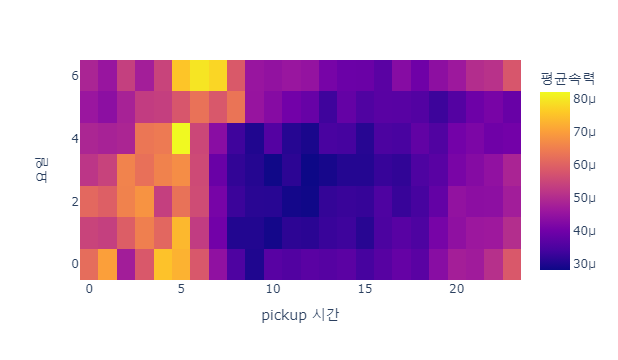

In [97]:
fig = px.density_heatmap(
    data_frame=tidydata,
    x='pickup_hour',
    y='dayofweek',
    z='sum of speed_mean',
    nbinsx=24,
    nbinsy=7
)
# fig.update_traces(colorbar=dict(title='평균속력'))
# fig.update_xaxes(title_text='pickup 시간')
# fig.update_yaxes(title_text='요일')

fig.update_layout(xaxis={'title':'pickup 시간'},
                 yaxis={'title':'요일'},
                 coloraxis_colorbar={'title':'평균속력'})

In [60]:
tidydata2 = df.pivot_table(index='pickup_hour', columns='dayofweek', values='dist', aggfunc = 'mean')\
.stack().reset_index().rename({0: 'sum of dist_mean'},axis=1)

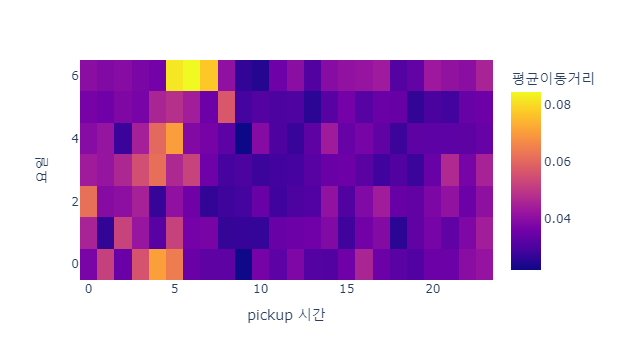

In [96]:
fig = px.density_heatmap(
    data_frame=tidydata2,
    x='pickup_hour',
    y='dayofweek',
    z='sum of dist_mean',
    nbinsx=24,
    nbinsy=7,
)
# fig.update_traces(colorbar=dict(title='평균속력'))
# fig.update_xaxes(title_text='pickup 시간')
# fig.update_yaxes(title_text='요일')

fig.update_layout(xaxis={'title':'pickup 시간'},
                 yaxis={'title':'요일'},
                 coloraxis_colorbar={'title':'평균이동거리'})

In [98]:
pcol = ['pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'pickup_hour']
dcol = ['dropoff_datetime', 'dropoff_longitude', 'dropoff_latitude', 'dropoff_hour']
def transform(df):
    pickup = df.loc[:,['id']+pcol].set_axis(['id', 'datetime', 'longitude', 'latitude', 'hour'],axis=1).assign(type = 'pickup')
    dropoff = df.loc[:,['id']+dcol].set_axis(['id', 'datetime', 'longitude', 'latitude', 'hour'],axis=1).assign(type = 'dropoff')
    return pd.concat([pickup,dropoff],axis=0)
df_left = df_small.drop(pcol+dcol,axis=1)
df_right = pd.concat([transform(df) for i, df in df_small.groupby('id')]).reset_index(drop=True)
df_feature_small2 = df_left.merge(df_right)

In [99]:
tidydata3 = df_feature_small2.assign(speed_cut = pd.qcut(df_feature_small2['speed'], 4,labels=['매우느림','조금느림','조금빠름','매우빠름']))\
.sort_values('speed_cut')

/root/anaconda3/envs/dv2023/lib/python3.10/site-packages/plotly/express/_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/root/anaconda3/envs/dv2023/lib/python3.10/site-packages/plotly/express/_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



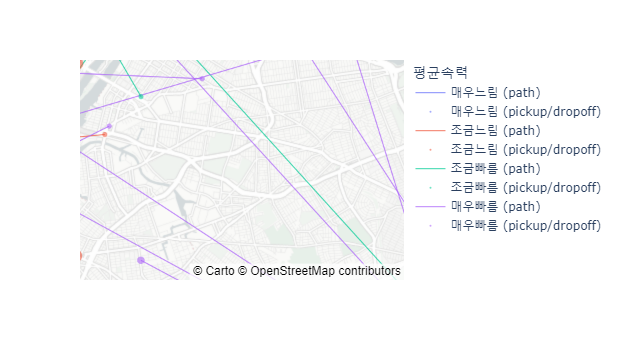

In [119]:
fig3 = px.line_mapbox(
    data_frame=tidydata3,
    lat = 'latitude',
    lon = 'longitude',
    line_group = 'id',
    color = 'speed_cut',
    center = {'lat':40.7322, 'lon':-73.9052},
    #---#
    mapbox_style = 'carto-positron',
    zoom=11,   
)
scatter_data = px.scatter_mapbox(
    data_frame=tidydata3,
    lat = 'latitude',
    lon = 'longitude',
    size = 'passenger_count',
    size_max = 10,
    color = 'speed_cut',
    #---#
    mapbox_style = 'carto-positron',
    zoom=10,
    width = 750,
    height = 600    
).data 
for sd in scatter_data: 
    fig3.add_trace(sd)
fig3.update_traces(
    line={
        'width':1
    },
    opacity=0.8
)
fig3.update_layout(legend_title='평균속력')
for i in range(150):
    if fig3.data[i].mode == 'lines':
        fig3.data[i]['name'] = fig3.data[i]['name']+' (path)'
    else :
        fig3.data[i]['name'] = fig3.data[i]['name']+' (pickup/dropoff)'
        
fig3.show(config={'scrollZoom':False})

In [104]:
fig3.data[1]

Scattermapbox({
    'hovertemplate': ('speed_cut=매우느림<br>id=id0616736' ... 'ongitude=%{lon}<extra></extra>'),
    'lat': array([40.76174927, 40.76351929]),
    'legendgroup': '매우느림',
    'line': {'color': '#636efa', 'width': 1},
    'lon': array([-73.97138977, -73.9693222 ]),
    'mode': 'lines',
    'name': '매우느림',
    'opacity': 0.8,
    'showlegend': False,
    'subplot': 'mapbox'
})

In [106]:
for i in range(150):
    if fig3.data[i].mode == 'lines':
        fig3.data[i]['legendgroup'] = fig3.data[i]['legendgroup']+' (path)'
        fig3.data[i]['name'] = fig3.data[i]['name']+' (path)'
    else :
        fig3.data[i]['legendgroup'] = fig3.data[i]['legendgroup']+' (pickup/dropoff)'
        fig3.data[i]['name'] = fig3.data[i]['name']+' (pickup/dropoff)'

In [113]:
fig3.data[1]

Scattermapbox({
    'hovertemplate': ('speed_cut=매우느림<br>id=id0616736' ... 'ongitude=%{lon}<extra></extra>'),
    'lat': array([40.76174927, 40.76351929]),
    'legendgroup': '매우느림 (path)',
    'line': {'color': '#636efa', 'width': 1},
    'lon': array([-73.97138977, -73.9693222 ]),
    'mode': 'lines',
    'name': '매우느림',
    'opacity': 0.8,
    'showlegend': False,
    'subplot': 'mapbox'
})

In [115]:
for i in range(150):
    print(fig3.data[i].legendgroup)

매우느림 (path)
매우느림 (path)
매우느림 (path)
매우느림 (path)
매우느림 (path)
매우느림 (path)
매우느림 (path)
매우느림 (path)
매우느림 (path)
매우느림 (path)
매우느림 (path)
매우느림 (path)
매우느림 (path)
매우느림 (path)
매우느림 (path)
매우느림 (path)
매우느림 (path)
매우느림 (path)
매우느림 (path)
매우느림 (path)
매우느림 (path)
매우느림 (path)
매우느림 (path)
매우느림 (path)
매우느림 (path)
매우느림 (path)
매우느림 (path)
매우느림 (path)
매우느림 (path)
매우느림 (path)
매우느림 (path)
매우느림 (path)
매우느림 (path)
매우느림 (path)
매우느림 (path)
매우느림 (path)
매우느림 (path)
조금느림 (path)
조금느림 (path)
조금느림 (path)
조금느림 (path)
조금느림 (path)
조금느림 (path)
조금느림 (path)
조금느림 (path)
조금느림 (path)
조금느림 (path)
조금느림 (path)
조금느림 (path)
조금느림 (path)
조금느림 (path)
조금느림 (path)
조금느림 (path)
조금느림 (path)
조금느림 (path)
조금느림 (path)
조금느림 (path)
조금느림 (path)
조금느림 (path)
조금느림 (path)
조금느림 (path)
조금느림 (path)
조금느림 (path)
조금느림 (path)
조금느림 (path)
조금느림 (path)
조금느림 (path)
조금느림 (path)
조금느림 (path)
조금느림 (path)
조금느림 (path)
조금느림 (path)
조금느림 (path)
조금빠름 (path)
조금빠름 (path)
조금빠름 (path)
조금빠름 (path)
조금빠름 (path)
조금빠름 (path)
조금빠름 (path)
조금빠름 (path)
조금빠름 (path)
조금빠름 (path)
조금빠름